In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame, roll_time_series, impute
from sklearn import preprocessing

In [2]:
file_path = 'KPI_new.csv'
source_data = pd.read_csv(file_path)
source_data.head()
df = source_data

In [3]:
df.head()

,timestamp,KPI
0,1535731200000,2163288
1,1535731500000,1589309
2,1535731800000,1354685
3,1535732100000,1248242
4,1535732400000,1132266


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
timestamp    4032 non-null int64
KPI          4032 non-null int64
dtypes: int64(2)
memory usage: 63.1 KB


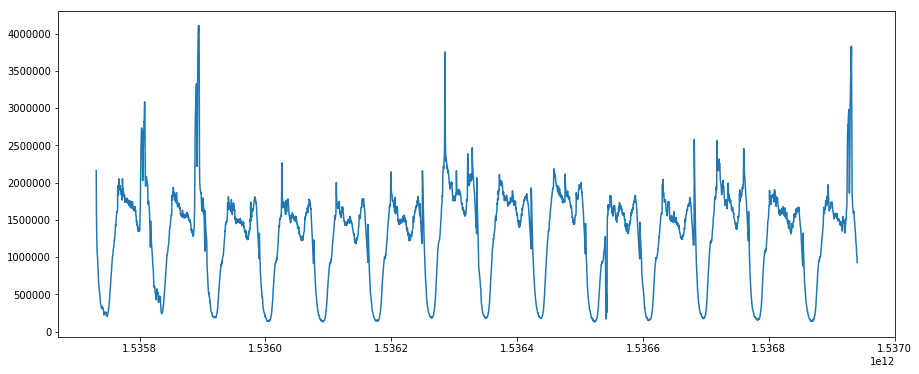

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(df.timestamp, df.KPI)
plt.show()

In [6]:
df_shift, y = make_forecasting_frame(df.KPI, kind='trade',max_timeshift=10, rolling_direction=1)

In [7]:
df_shift.head()

,time,value,id,kind
36234,0.0,2163288.0,1,trade
32204,0.0,2163288.0,2,trade
36235,1.0,1589309.0,2,trade
28175,0.0,2163288.0,3,trade
32205,1.0,1589309.0,3,trade


In [8]:
y.head()

1    1589309
2    1354685
3    1248242
4    1132266
5    1058135
Name: value, dtype: int64

In [10]:
from tsfresh import extract_features
df_extracted = extract_features(df_shift, column_id='id', column_sort='time', column_value="value",impute_function=impute)


Feature Extraction: 100%|██████████| 20/20 [01:06<00:00,  2.73s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_tr

In [11]:
df_extracted.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
1,4.679815e+12,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2,7.205718e+12,573979.0,-1.000000,-1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,8.236297e+10,1.0
3,9.040890e+12,808603.0,-0.722273,-0.722273,0.444646,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,-4.521018e+18,0.000000e+00,0.0,0.0,0.0,0.0,1.153710e+11,1.0
4,1.059900e+13,915046.0,-0.629252,-0.537790,0.529591,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,-2.916037e+18,0.000000e+00,0.0,0.0,0.0,0.0,1.252066e+11,1.0
5,1.188102e+13,1031022.0,-0.601384,-0.455644,0.640595,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,-2.174178e+18,-4.602933e+18,0.0,0.0,0.0,0.0,1.335248e+11,1.0


In [12]:
df_extracted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4031 entries, 1 to 4031
Columns: 794 entries, value__abs_energy to value__variance_larger_than_standard_deviation
dtypes: float64(794)
memory usage: 24.4 MB


In [13]:
df_extracted.to_csv('df_extracted.csv', index=False)

In [15]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(n_estimators=300, learning_rate=0.1)

from tqdm import tqdm

y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]

for i in tqdm(range(1, len(y))):
    ada.fit(df_extracted.iloc[:i], y[:i])
    y_pred[i] = ada.predict(df_extracted.iloc[i, :].values.reshape((1, -1)))
    
y_pred = pd.Series(data=y_pred, index=y.index)


  8%|▊         | 308/4030 [05:45<2:12:43,  2.14s/it]


 15%|█▍        | 600/4030 [20:42<3:30:06,  3.68s/it]


 22%|██▏       | 892/4030 [44:27<5:03:18,  5.80s/it]


 29%|██▉       | 1175/4030 [1:19:26<8:04:42, 10.19s/it]


 36%|███▌      | 1451/4030 [2:08:44<7:27:26, 10.41s/it]


 43%|████▎     | 1727/4030 [3:03:29<8:23:18, 13.11s/it]


 50%|████▉     | 2003/4030 [4:12:10<10:08:23, 18.01s/it]


 57%|█████▋    | 2278/4030 [5:31:29<8:33:55, 17.60s/it]


 63%|██████▎   | 2554/4030 [7:00:19<9:21:33, 22.83s/it]


 70%|███████   | 2830/4030 [8:45:25<8:16:52, 24.84s/it]


 77%|███████▋  | 3105/4030 [10:42:02<6:27:09, 25.11s/it]


 84%|████████▍ | 3377/4030 [12:47:57<4:48:19, 26.49s/it]


 91%|█████████ | 3649/4030 [14:53:53<3:04:15, 29.02s/it]


 97%|█████████▋| 3921/4030 [17:11:14<57:15, 31.52s/it]


100%|██████████| 4030/4030 [18:09:22<00:00, 32.41s/it]


In [17]:
y_pred

1                    1589309
2                [1589309.0]
3                [1589309.0]
4                [1248242.0]
5                [1132266.0]
6                [1058135.0]
7                [1058135.0]
8                 [971826.0]
9                 [884944.0]
10       [845571.3333333334]
11                [884944.0]
12                [771212.0]
13                [726499.0]
14                [684173.8]
15       [642932.3333333334]
16                [622459.0]
17               [598043.25]
18       [574886.6666666666]
19                [563986.0]
20                [527051.5]
21       [494590.6666666667]
22      [467808.71428571426]
23                [437930.0]
24                [417470.0]
25                [399442.0]
26       [402467.8333333333]
27                [388047.5]
28      [371090.54545454547]
29       [352309.3333333333]
30      [346150.85714285716]
                ...         
4002      [3555307.29209622]
4003    [3232470.0436241613]
4004    [2337451.8086560364]
4005    [21797

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 预测是从第二点开始的，所以这边的误差比较会忽略第一个点

error = mean_squared_error(y.values, y_pred)
print('Test MSE: %.3f' % error)
error = mean_absolute_error(y.values, y_pred)
print('Test MAE: %.3f' % error)

Test MSE: 16259547538.830
Test MAE: 88614.351


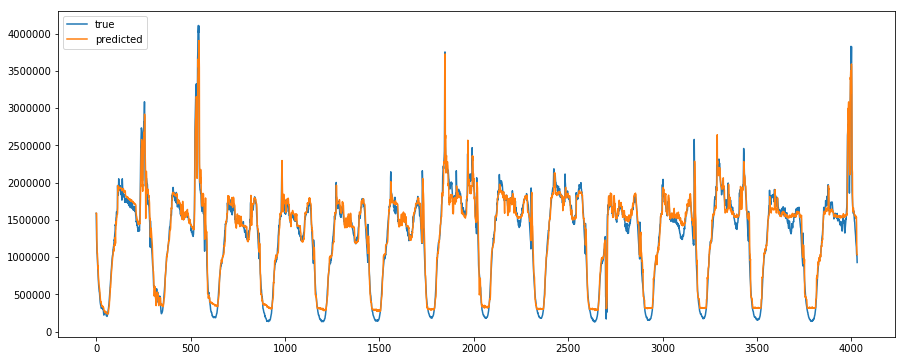

In [23]:
plt.figure(figsize=(15, 6))
plt.plot(y.values, label="true")
plt.plot(y_pred.values, label="predicted")
plt.legend()
plt.show()

In [1]:
y_pred.to_csv('tsfresh_AdaBoost_prediction_MAE_88614.csv')

NameError: name 'y_pred' is not defined